In [1]:
# Imports
from utils import *

Data Ingestion

In [2]:
base_path = os.getcwd()
path = os.path.join(base_path , 'Fortune 500 2017 - Fortune 500.csv')
frt_500 = pd.read_csv(path)
# Rank seems to be pretty useless - it is based on Revenue 
frt_500 = frt_500.drop('Rank' , axis = 1)

Feature Engg

In [3]:
def feature_engg_chain(data_0,target_0,scaler):
    '''
    perform feature engg and return df of independent vars and series of dependent vars
    params: data_0 -> input dataframe w/o target var
    params: target_0 -> target var/ dependent var
    params: feature_sc -> sklearn scaler object
    returns: data_sd -> dataframe containing standardized numerical values and unstandardized categorical values (encoded as numbers) and standardized dependent variable 
    '''

    # Some transformations
    # 1. HQZIP shouldn't be int64 - it is a categorical variable
    data = data_0.copy()
    data['Hqzip'] = data['Hqzip'].astype('str').str.zfill(5)
    # 2. Prftchange shouldn't be an object - it is a float. However it needs to be preprocessed - there are some commas etc
    try:
        data['Prftchange'] = data['Prftchange'].astype('float')
    except:
        data['Prftchange'] = data['Prftchange'].apply(lambda x : x.replace(',',''))
        data['Prftchange'] = data['Prftchange'].astype('float')
    
    # Does Geography play a role?
    # Can we encode zip into lat-long info?
    nomi = pgeocode.Nominatim('us')
    data['lat'] = data['Hqzip'].apply(lambda x: nomi.query_postal_code(x).latitude)
    data['long'] = data['Hqzip'].apply(lambda x: nomi.query_postal_code(x).longitude) 

    num_cov = list(data.describe().columns)
    cat_cov = list(data.describe(include = 'object').columns)

    num_data = data.loc[: , num_cov]
    cat_data = data.loc[: , cat_cov]

    # cat_data also has some info in it that may be useful in predicting rev / clustering. Let's label encode them.
    le_1 = LabelEncoder()
    le_2 = LabelEncoder()

    l_encoded_sector = le_1.fit_transform(cat_data.Sector)
    l_encoded_industry = le_2.fit_transform(cat_data.Industry)

    # Remove multicollinearity
    num_data['Profits_per_asset'] = num_data['Profits']/num_data['Assets'] # profit per asset
    num_data['Totshequity_per_asset'] = num_data['Totshequity']/num_data['Assets'] # Totshequity per asset
    num_data.drop(['Profits' , 'Totshequity'] , axis = 1 , inplace = True)
    
    # Scaling independent vars
    num_data_sd = pd.DataFrame(scaler.fit_transform(num_data) , columns = num_data.columns)

    X_sd = pd.concat([
        num_data_sd,
        pd.Series(l_encoded_sector , name = 'sector') , 
        pd.Series(l_encoded_industry , name = 'industry')
    ], axis=1).reset_index().drop('index',axis = 1) # otherwise some nans are introduced due to concat. not fully reproducible yet 
    
    target_sd = pd.DataFrame(np.log10(target_0), columns = ["Revenues"]).reset_index().drop('index',axis = 1) # otherwise some nans are introduced due to concat. not fully reproducible yet
    data_sd = pd.concat([X_sd , target_sd], axis = 1)
    return data_sd

In [4]:
feature_sc = StandardScaler()
data_sd = feature_engg_chain(
    frt_500[[col for col in frt_500 if col!="Revenues"]], 
    frt_500.Revenues, 
    scaler=feature_sc
    )

In [5]:
data_sd.isnull().sum()

Employees                0
Revchange                0
Prftchange               0
Assets                   0
lat                      0
long                     0
Profits_per_asset        0
Totshequity_per_asset    0
sector                   0
industry                 0
Revenues                 0
dtype: int64

In [6]:
data_sd

,Employees,Revchange,Prftchange,Assets,lat,long,Profits_per_asset,Totshequity_per_asset,sector,industry,Revenues
0,18.192467,-0.148289,-0.052097,0.438399,-0.472434,-0.329494,0.368724,0.575123,16,25,5.686523
1,2.524557,0.117408,-0.040993,2.000571,0.630835,-0.444606,-0.096259,0.884388,6,38,5.349480
2,0.483666,-0.574408,-0.063202,0.893178,-0.259282,-2.155176,1.512471,0.610531,17,11,5.333727
3,0.132572,-1.025592,-0.120421,0.925115,-1.262526,-0.508553,-0.330610,1.127531,4,49,5.311762
4,0.094462,0.122421,0.040749,-0.088195,-0.152491,-2.178584,-0.078426,-0.543918,20,72,5.284401
...,...,...,...,...,...,...,...,...,...,...,...
495,-0.205550,0.102369,-0.034515,-0.289616,-1.250122,-0.509924,2.042968,-5.088142,16,59,3.715753
496,-0.422855,1.009750,-0.032973,-0.261525,0.386671,0.920650,-0.088991,0.781345,5,30,3.713491
497,-0.387989,0.012132,-0.032973,-0.119584,-0.241171,-2.152271,-0.769874,1.794467,17,39,3.713407
498,-0.420982,0.012132,-0.032973,-0.241426,-1.280411,-0.499732,-0.920583,0.784387,4,16,3.712986


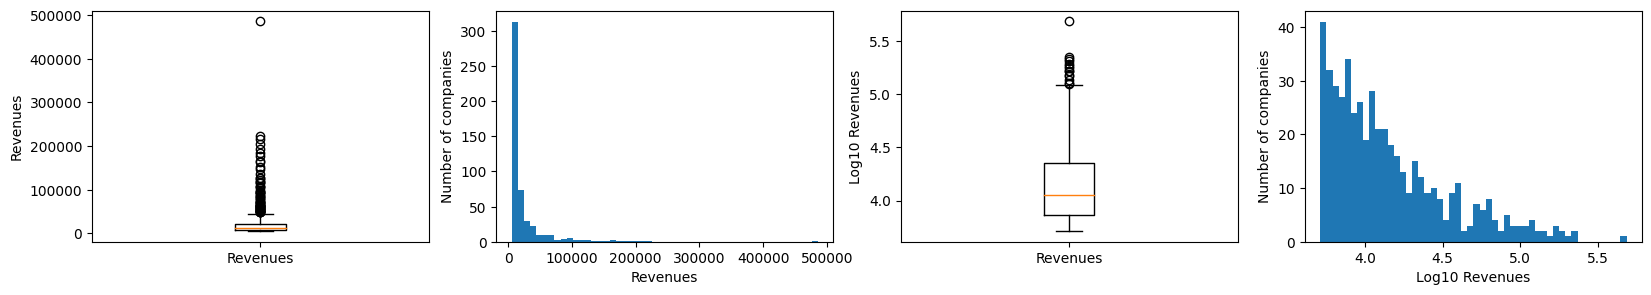

In [7]:
fig, ax = plt.subplots(1,4 , figsize = (20,3))

ax[0].boxplot(frt_500.Revenues);
ax[0].set_xticklabels(['Revenues']);
ax[0].set_ylabel('Revenues');

ax[1].hist(frt_500.Revenues , bins = 50)
ax[1].set_xlabel('Revenues');
ax[1].set_ylabel('Number of companies');

ax[2].boxplot(np.log10(frt_500.Revenues));
ax[2].set_xticklabels(['Revenues']);
ax[2].set_ylabel('Log10 Revenues');

ax[3].hist(np.log10(frt_500.Revenues) , bins = 50)
ax[3].set_xlabel('Log10 Revenues');
ax[3].set_ylabel('Number of companies');

### **Clustering**

In [8]:
data_sd.head(3)

,Employees,Revchange,Prftchange,Assets,lat,long,Profits_per_asset,Totshequity_per_asset,sector,industry,Revenues
0,18.192467,-0.148289,-0.052097,0.438399,-0.472434,-0.329494,0.368724,0.575123,16,25,5.686523
1,2.524557,0.117408,-0.040993,2.000571,0.630835,-0.444606,-0.096259,0.884388,6,38,5.349480
2,0.483666,-0.574408,-0.063202,0.893178,-0.259282,-2.155176,1.512471,0.610531,17,11,5.333727


In [9]:
n = 2
pca = PCA(n_components=n)
prin_comp = pca.fit_transform(data_sd)
prin_comp_df = pd.DataFrame(prin_comp , columns = ['PC'+str(comp) for comp in range(1,n+1)])
print(prin_comp.shape , pca.explained_variance_ratio_ , sum(pca.explained_variance_ratio_)) # about 98% var is explained. great

(500, 2) [0.92257899 0.06093741] 0.983516396955755


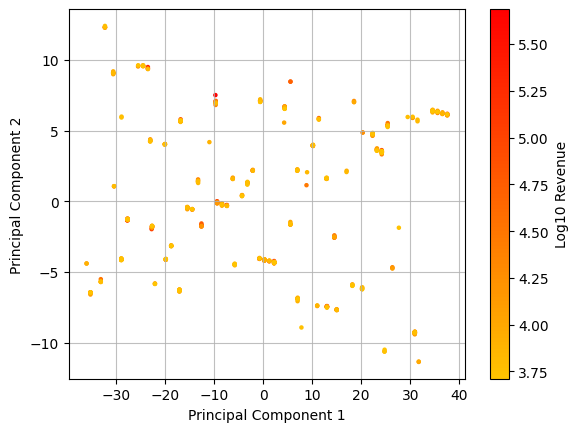

In [10]:
cmap = LinearSegmentedColormap.from_list('custom blue', [(0,'#ffc400'),(1,'#ff0000')], N=100)

fig , ax = plt.subplots()

ax1 = ax.scatter(prin_comp_df.PC1 , prin_comp_df.PC2 , c = data_sd['Revenues'] , s = 5, cmap=cmap)
ax.grid(alpha = 0.8);
# ax.set_xscale('log');
ax.set_xlabel('Principal Component 1')

# ax.set_yscale('log');
ax.set_ylabel('Principal Component 2');

cbar = fig.colorbar(ax1)
cbar.set_label('Log10 Revenue')

In [11]:
# Scale Features before clustering
scaler = StandardScaler()
scaled_features = scaler.fit_transform(prin_comp_df)

DBSCAN

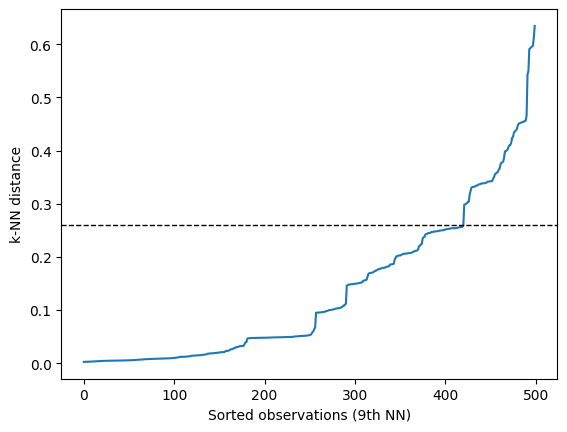

In [12]:
# n_neighbors = 5 as kneighbors function returns distance of point to itself (i.e. first column will be zeros) 
n = 10
neighbours = NearestNeighbors(n_neighbors=n)
neighbours_fit = neighbours.fit(scaled_features)
# Find the k-neighbors of a point
neighbours_dist, _ = neighbours.kneighbors(scaled_features)

k_dist = np.sort(neighbours_dist[: , n-1])

plt.plot(k_dist)
plt.axhline(y=0.26, linewidth=1, linestyle='dashed', color='k')
plt.ylabel("k-NN distance")
plt.xlabel(f"Sorted observations ({n-1}th NN)")
plt.show()

In [13]:
clusters = DBSCAN(eps=0.26, min_samples=10).fit(scaled_features)
# get cluster population
counted = Counter(clusters.labels_)
counted.get(-1)

70

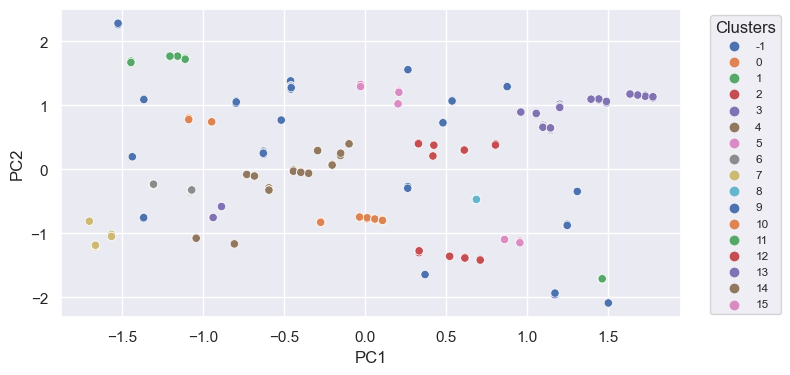

In [14]:
sns.set(rc={'figure.figsize':(8,4),'legend.fontsize':8.5})
p = sns.scatterplot(data=pd.DataFrame(scaled_features ,columns = ["PC1","PC2"]), x="PC1", y="PC2", hue=clusters.labels_, legend="full", palette="deep")
sns.move_legend(p, "upper right", bbox_to_anchor=(1.17, 1), title='Clusters')
plt.show()

In [15]:
# Grid Search through DBSCAN params
min_samples = [5,10,20,25,30,50]
eps = [0.01,0.05,0.1,0.25,0.4]

outliers = {}

import itertools
for samples , eps in itertools.product(min_samples,eps):
    clusters = DBSCAN(eps=eps, min_samples=samples).fit(scaled_features)
    # get cluster population
    counted = Counter(clusters.labels_)
    outliers[(samples,eps)] = counted.get(-1)

# Combination with least outliers
print(combo := min(outliers , key = outliers.get))
samples , eps = combo

(5, 0.4)


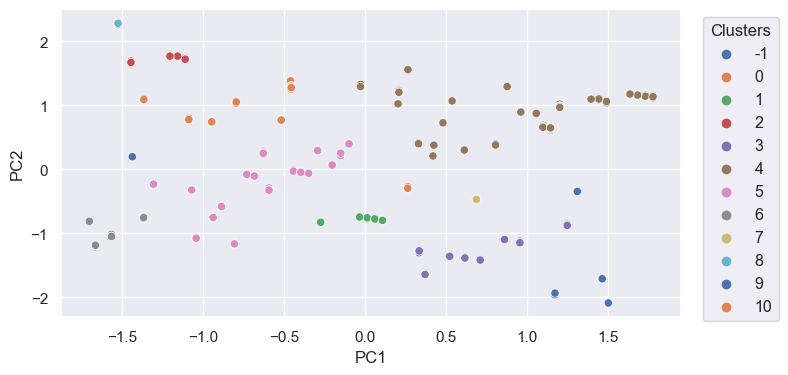

In [16]:
clusters = DBSCAN(eps=eps, min_samples=samples).fit(scaled_features)
# get cluster population
counted = Counter(clusters.labels_)

sns.set(rc={'figure.figsize':(8,4),'legend.fontsize':11.5})
p = sns.scatterplot(data=pd.DataFrame(scaled_features ,columns = ["PC1","PC2"]), x="PC1", y="PC2", hue=clusters.labels_, legend="full", palette="deep")
sns.move_legend(p, "upper right", bbox_to_anchor=(1.17, 1), title='Clusters')
plt.show()

K-Means

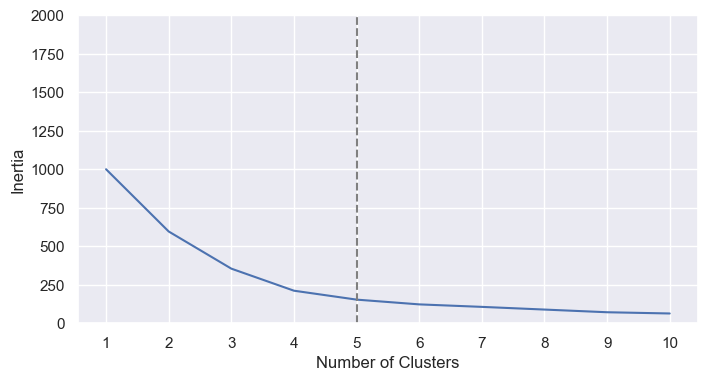

In [17]:
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"max_iter": 300,
"random_state": SEED,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.vlines(5, ymin = 0, ymax = 2000 , ls = '--' , color = 'gray');
plt.ylim(0,2000);
plt.show()

         cluster
cluster         
0            123
1             69
2             93
3            144
4             71


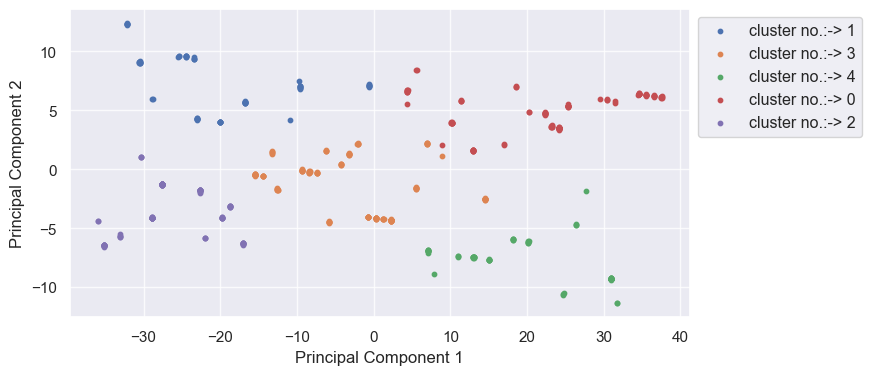

In [18]:
kmeans = KMeans(
init="random",
n_clusters=5,
n_init=10,
max_iter=300,
random_state=SEED
)

kmeans.fit(scaled_features)

labels = kmeans.labels_

prin_comp_df['cluster'] = labels
print(prin_comp_df.groupby('cluster').agg({'cluster':'count'}))

fig , ax = plt.subplots()

for cluster in prin_comp_df.cluster.unique():
    df = prin_comp_df[
        prin_comp_df['cluster'] == cluster
    ]

    ax.scatter(df.PC1 , df.PC2 , label = f'cluster no.:-> {cluster}' , s = 10)
    ax.legend(loc = 'best')
    ax.grid(alpha = 0.8);
    # ax.set_xscale('log');
    ax.set_xlabel('Principal Component 1')

    # ax.set_yscale('log');
    ax.set_ylabel('Principal Component 2');

plt.legend(loc = 'best', bbox_to_anchor = (1,1));

### **Cluster Profiling**

In [19]:
# Inverse Transforms
num_cov = ['Employees','Revchange','Prftchange','Assets','lat','long','Profits_per_asset','Totshequity_per_asset']
num_data = pd.DataFrame(feature_sc.inverse_transform(data_sd[num_cov]) , columns = num_cov)

y = 10**(data_sd.Revenues)

sector_industry = data_sd[['sector','industry']]

data_clustered = pd.concat(
    [
        frt_500.Title,
        frt_500.Sector,
        num_data,
        sector_industry,
        pd.Series(labels, name='cluster'),
        y
    ],
    axis = 1
)

In [20]:
data_clustered.groupby(
    [
        'cluster',
        'Sector'
        ]
    ).agg({'Title':'count'}).reset_index().pivot_table(
    index = 'Sector' , columns = 'cluster').fillna(0)

Title                        
cluster                           0     1     2     3     4
Sector                                                     
Aerospace & Defense             0.0   0.0  12.0   0.0   0.0
Apparel                         0.0   0.0   5.0   0.0   0.0
Business Services               0.0   0.0  14.0   0.0   6.0
Chemicals                       0.0   0.0  14.0   0.0   0.0
Energy                          0.0   0.0   7.0   0.0  50.0
Engineering & Construction      0.0   0.0   7.0   6.0   0.0
Financials                      0.0   0.0  31.0  42.0  11.0
Food & Drug Stores              0.0   0.0   0.0   7.0   0.0
Food, Beverages & Tobacco       0.0   0.0   3.0  18.0   3.0
Health Care                     0.0   0.0   0.0  38.0   0.0
Hotels, Restaurants & Leisure   0.0   0.0   0.0  10.0   0.0
Household Products              0.0   0.0   0.0  11.0   1.0
Industrials                     0.0  13.0   0.0   6.0   0.0
Materials                      10.0   3.0   0.0   6.0   0.0
Media                           2.0   9.0   0.0   0.0   0.0
Motor Vehicles & Parts          9.0   0.0   0.0   0.0   0.0
Retailing                      29.0  18.0   0.0   0.0   0.0
Technology                     23.0  20.0   0.0   0.0   0.0
Telecommunications             10.0   0.0   0.0   0.0   0.0
Transportation                 11.0   6.0   0.0   0.0   0.0
Wholesalers                    29.0   0.0   0.0   0.0   0.0

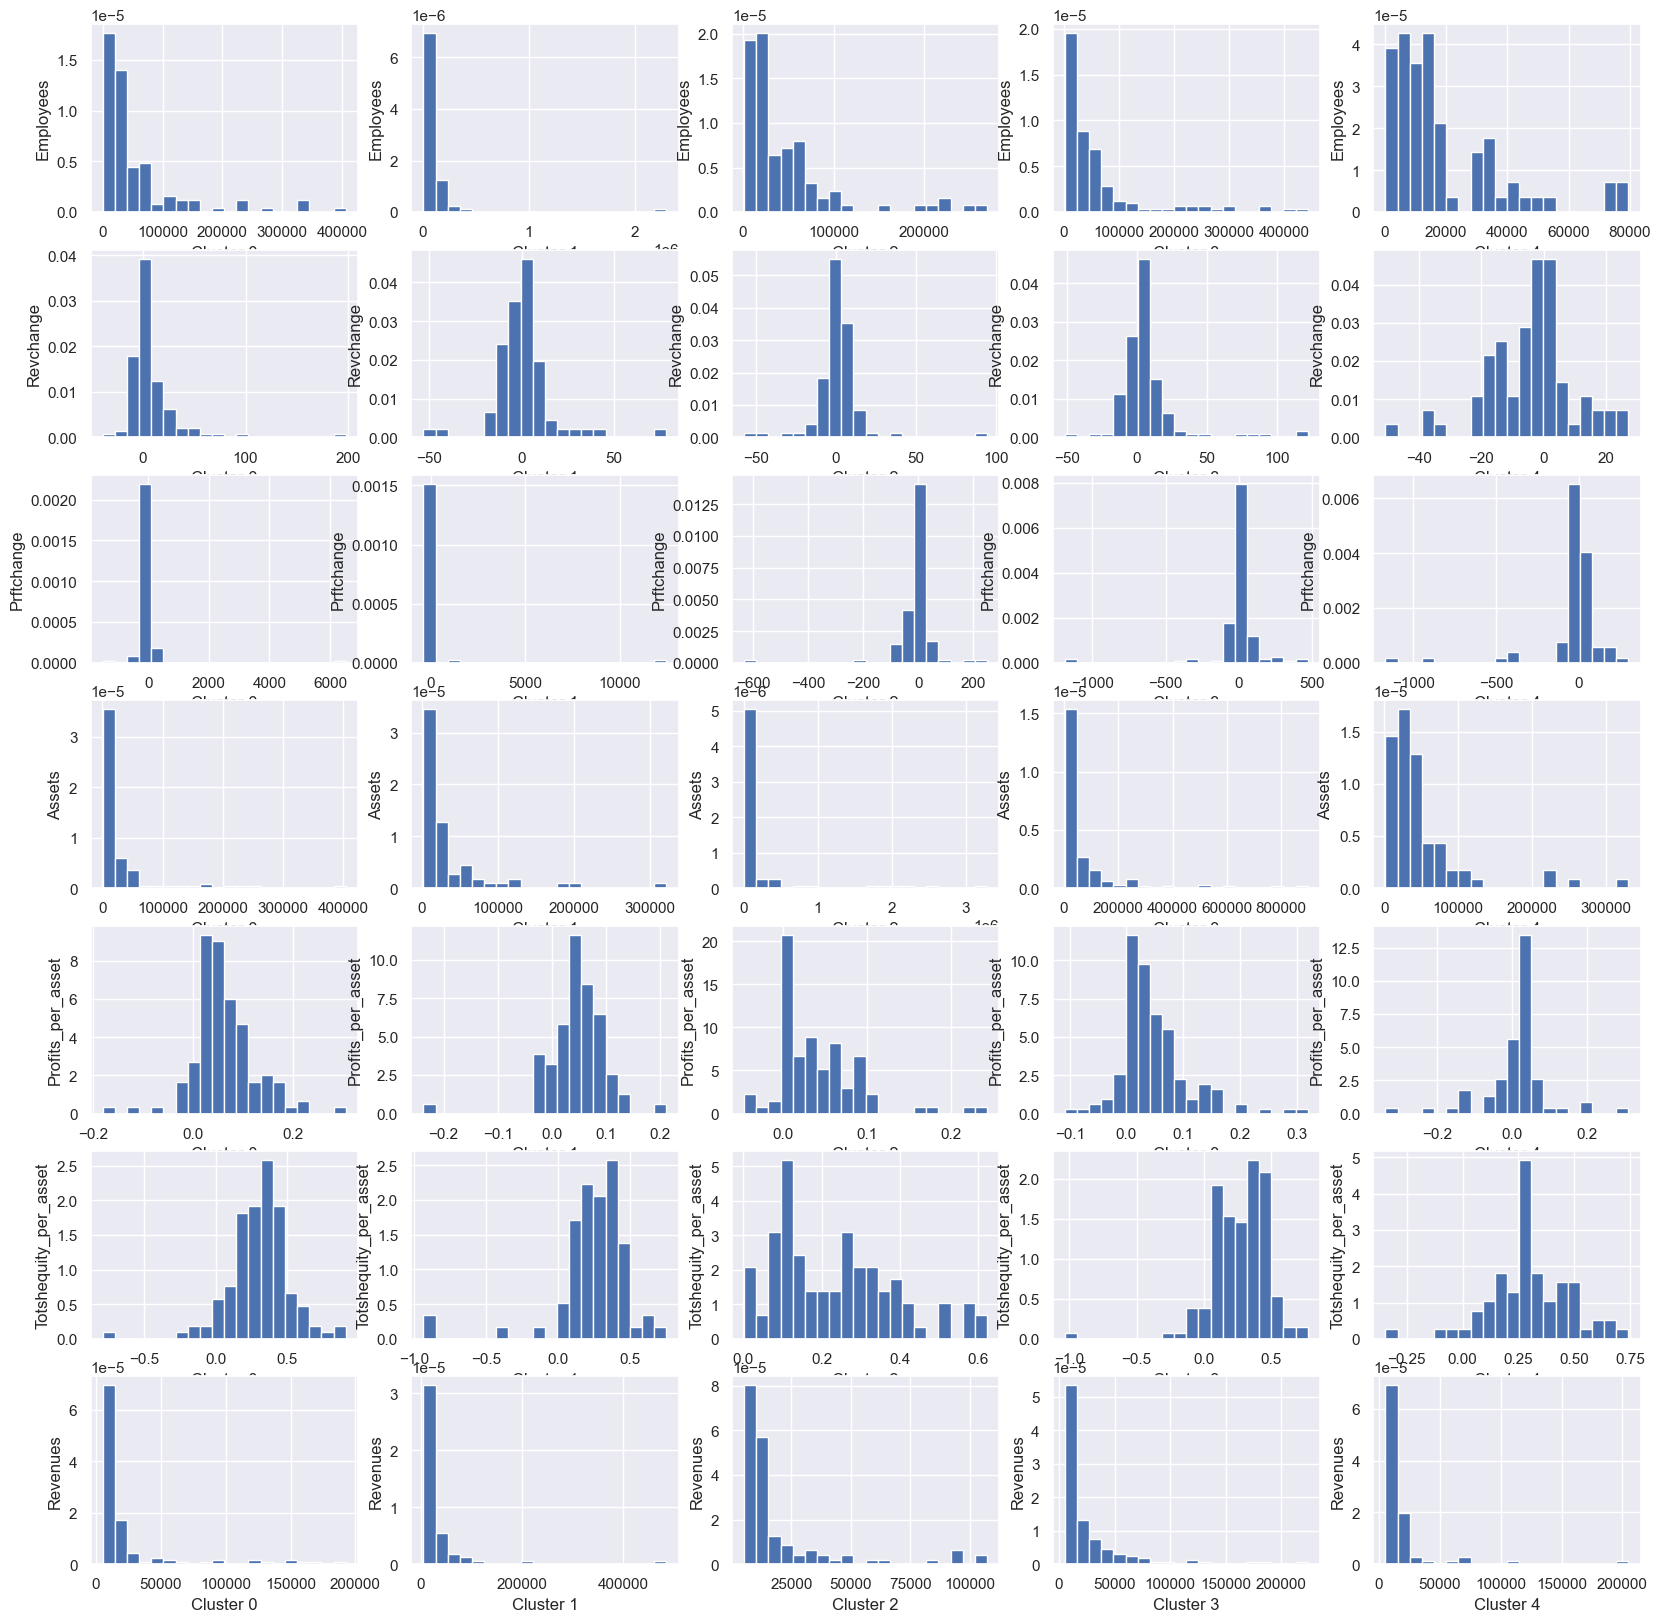

In [21]:
numeric_cols = ['Employees', 'Revchange', 'Prftchange', 'Assets', 'Profits_per_asset', 'Totshequity_per_asset', 'Revenues']

fig, ax = plt.subplots(len(numeric_cols), data_clustered.cluster.nunique() , figsize = (20,20))

for row_idx, row in enumerate(numeric_cols):
    for cluster in data_clustered.cluster.unique():
        ax[row_idx][cluster].hist(data_clustered[data_clustered['cluster'] == cluster][row] , bins = 20, density=True)
        ax[row_idx][cluster].set_xlabel(f'Cluster {cluster}')
        ax[row_idx][cluster].set_ylabel(f'{row}')

### **Regression**

In [22]:
frt_500 = pd.concat([
    frt_500,
    pd.Series(labels, name='cluster')
] , axis = 1)
X = frt_500[[col for col in frt_500.columns if col!="Revenues"]]
y = frt_500["Revenues"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [23]:
X_train.head(2)

,Title,Website,Employees,Sector,Industry,Hqlocation,Hqaddr,Hqcity,Hqstate,Hqzip,...,Ceo-title,Address,Ticker,Fullname,Revchange,Profits,Prftchange,Assets,Totshequity,cluster
13,Verizon,http://www.verizon.com,160900,Telecommunications,Telecommunications,"New York, NY",1095 Ave. of the Americas,New York,NY,10036,...,Chairman & Chief Executive Officer,"1095 Ave. of the Americas, New York, NY 10036",VZ,Verizon Communications Inc.,-4.3,13127.0,-26.6,244180,22524.0,0
61,Dow Chemical,http://www.dow.com,56000,Chemicals,Chemicals,"Midland, MI",2030 Dow Center,Midland,MI,48674,...,Chairman & Chief Executive Officer,"2030 Dow Center, Midland, MI 48674",DOW,The Dow Chemical Company,-1.3,4318.0,-43.8,79511,25987.0,2


In [24]:
train_scaler = StandardScaler()
train_df = feature_engg_chain(X_train , y_train , train_scaler)
X_train_df = train_df[[col for col in train_df if col!='Revenues']]
y_train_df =train_df.Revenues

test_scaler = StandardScaler()
test_df = feature_engg_chain(X_test , y_test , test_scaler)
X_test_df = test_df[[col for col in test_df if col!='Revenues']]
y_test_df =test_df.Revenues

In [25]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_df.drop('industry',axis = 1).columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train_df.drop('industry',axis = 1).values, i)
                          for i in range(len(X_train_df.drop('industry',axis = 1).columns))]

vif_data

,feature,VIF
0,Employees,1.035120
1,Revchange,1.051362
2,Prftchange,1.037229
3,Assets,1.051835
4,cluster,1.287694
5,lat,1.082189
6,long,1.153835
7,Profits_per_asset,1.214958
8,Totshequity_per_asset,1.227617
9,sector,1.192492


Linear Regression

In [26]:
# OLS
X_train_c = sm.add_constant(X_train_df.drop('industry',axis = 1))
X_test_c = sm.add_constant(X_test_df.drop('industry',axis = 1))

model = sm.OLS(y_train_df,X_train_c)
res = model.fit()
print(res.summary())
# Not a great model. Let's drop some features

                            OLS Regression Results                            
Dep. Variable:               Revenues   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     18.23
Date:                Tue, 06 Dec 2022   Prob (F-statistic):           1.20e-26
Time:                        23:42:01   Log-Likelihood:                -87.823
No. Observations:                 350   AIC:                             197.6
Df Residuals:                     339   BIC:                             240.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     4.08

In [27]:
# OLS
X_train_c = sm.add_constant(X_train_df[['Employees','Revchange','Assets']])
X_test_c = sm.add_constant(X_test_df[['Employees','Revchange','Assets']])

model = sm.OLS(y_train_df,X_train_c)
res = model.fit()
print(res.summary())
# Not a great model. Let's drop some features

                            OLS Regression Results                            
Dep. Variable:               Revenues   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     58.44
Date:                Tue, 06 Dec 2022   Prob (F-statistic):           1.38e-30
Time:                        23:42:01   Log-Likelihood:                -91.393
No. Observations:                 350   AIC:                             190.8
Df Residuals:                     346   BIC:                             206.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1705      0.017    246.922      0.0

In [28]:
y_pred = res.predict(X_test_c)

mean_absolute_percentage_error(y_pred , y_test_df)

0.05476058156081879

In [29]:
mse = np.sqrt(np.sum((10**(y_pred) - 10**(y_test_df))**2))
mape = np.mean(abs((10**(y_pred) - 10**(y_test_df))/10**(y_test_df)))

mse , mape

(697705.9979695117, 0.6100957049247575)

ElasticNet

In [30]:
# Ridge
regr = Ridge(alpha=1.5,)
regr.fit(X_train_df, y_train_df)
print(regr.coef_)
print(regr.intercept_)

[ 1.59971890e-01 -3.96624303e-02 -1.93533781e-02  1.36566624e-01
  3.70485695e-02  1.46973381e-02  4.00984705e-03  1.78468493e-02
  1.31392798e-02  8.11558081e-03  6.82473752e-05]
4.089511820320428


In [31]:
y_pred = 10**(regr.predict(X_test_df))
mean_absolute_percentage_error(y_pred , y_test)

0.6238522124265885

In [32]:
# LASSO
regr = Lasso(alpha=0.1, )
regr.fit(X_train_df, y_train_df)
print(regr.coef_)
print(regr.intercept_)

[ 0.07412867 -0.         -0.          0.03953588 -0.          0.
  0.          0.         -0.          0.00026012 -0.00028391]
4.177602135447265


In [33]:
y_pred = 10**(regr.predict(X_test_df))
mean_absolute_percentage_error(y_pred , y_test)

0.7980509273892195

Polynomial Regression

In [34]:
poly = PolynomialFeatures(degree = 3)
X_train_poly_fit = poly.fit_transform(X_train_df[['industry', 'Assets', 'Employees']])

In [35]:
regr = ElasticNet(alpha=0.5, l1_ratio=0.3, fit_intercept=True, )
regr.fit(pd.DataFrame(X_train_poly_fit).drop(5,axis=1), y_train_df)
print(regr.coef_)
print(regr.intercept_)

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  1.47260614e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.03093299e-06  2.86391872e-04 -1.14063106e-04
  4.51489349e-05 -0.00000000e+00 -1.32596643e-03  5.34653386e-04
  1.31797366e-03  0.00000000e+00  1.21170650e-03]
4.169407089978244


c:\Users\soura\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.984e-01, tolerance: 5.205e-03
  model = cd_fast.enet_coordinate_descent(


In [36]:
X_test_poly_fit = poly.fit_transform(X_test_df[['industry', 'Assets', 'Employees']])

y_pred = regr.predict(pd.DataFrame(X_test_poly_fit).drop(5,axis=1))

mean_absolute_percentage_error(10**(y_pred) , 10**(y_test_df))

0.5282591739137217

MLP

In [37]:
regr = MLPRegressor(
    hidden_layer_sizes=1000, activation='relu', solver='lbfgs', alpha=0.01, random_state = SEED
)

regr_fit = regr.fit(X_train_df , y_train_df)

y_pred = regr_fit.predict(X_test_df)

# Inverse transforming before checking erro
mean_absolute_percentage_error(10**(y_pred) , 10**(y_test_df))

c:\Users\soura\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


0.5113034375284204

Ensemble Models

In [38]:
# https://machinelearningmastery.com/xgboost-for-regression/
model = XGBRegressor(n_estimators=500, max_depth=5, eta=0.05, subsample=0.7, colsample_bytree=0.5,random_state=SEED)

# define model evaluation method
cv = RepeatedKFold(n_splits=15, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train_df, y_train_df, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = abs(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()))

Mean MAE: 0.153 (0.026)


In [39]:
model.fit(X_train_df, y_train_df, )
# make a prediction
yhat = model.predict(X_test_df)

In [40]:
mean_absolute_percentage_error(10**yhat , 10**y_test_df)

0.43717889769232915

In [41]:
# https://machinelearningmastery.com/xgboost-for-regression/
model = RandomForestRegressor(n_estimators=100, criterion='squared_error', max_depth=5, min_samples_split=2, min_samples_leaf=1, 
min_weight_fraction_leaf=0.0, max_features=1.0, max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, 
n_jobs=-1, warm_start=False, ccp_alpha=0.0, max_samples=None,random_state=SEED)

# define model evaluation method
cv = RepeatedKFold(n_splits=15, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train_df, y_train_df, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = abs(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()))

Mean MAE: 0.164 (0.029)


In [42]:
model.fit(X_train_df, y_train_df, )
# make a prediction
yhat = model.predict(X_test_df)

mean_absolute_percentage_error(10**yhat , 10**y_test_df)

0.42913943643809527

In [43]:
pd.DataFrame(list(zip(X_train_df.columns , model.feature_importances_)), columns = ['features','importance'])

,features,importance
0,Employees,0.382647
1,Revchange,0.013447
2,Prftchange,0.013849
3,Assets,0.474208
4,cluster,0.004374
5,lat,0.017022
6,long,0.013682
7,Profits_per_asset,0.028898
8,Totshequity_per_asset,0.025091
9,sector,0.011157


### **CLUSTERING**

In [44]:
X_0 = frt_500[[col for col in frt_500 if col!="cluster"]]
y = frt_500['cluster']

In [45]:
scaler = StandardScaler()

data = X_0.copy()

data['Hqzip'] = data['Hqzip'].astype('str').str.zfill(5)
# 2. Prftchange shouldn't be an object - it is a float. However it needs to be preprocessed - there are some commas etc
try:
    data['Prftchange'] = data['Prftchange'].astype('float')
except:
    data['Prftchange'] = data['Prftchange'].apply(lambda x : x.replace(',',''))
data['Prftchange'] = data['Prftchange'].astype('float')
    
nomi = pgeocode.Nominatim('us')
data['lat'] = data['Hqzip'].apply(lambda x: nomi.query_postal_code(x).latitude)
data['long'] = data['Hqzip'].apply(lambda x: nomi.query_postal_code(x).longitude) 

num_cov = list(data.describe().columns)
cat_cov = list(data.describe(include = 'object').columns)

num_data = data.loc[: , num_cov]
cat_data = data.loc[: , cat_cov]

# cat_data also has some info in it that may be useful in predicting rev / clustering. Let's label encode them.
le_1 = LabelEncoder()
le_2 = LabelEncoder()

l_encoded_sector = le_1.fit_transform(cat_data.Sector)
l_encoded_industry = le_2.fit_transform(cat_data.Industry)

# Remove multicollinearity
num_data['Profits_per_asset'] = num_data['Profits']/num_data['Assets'] # profit per asset
num_data['Totshequity_per_asset'] = num_data['Totshequity']/num_data['Assets'] # Totshequity per asset
num_data.drop(['Profits' , 'Totshequity'] , axis = 1 , inplace = True)
    
# Scaling independent vars
num_data_sd = pd.DataFrame(scaler.fit_transform(num_data) , columns = num_data.columns)

# Adding sector and industry
X = pd.concat(
    [
        num_data_sd,
        pd.Series(l_encoded_sector,name='sector'),
        pd.Series(l_encoded_industry,name='industry'),
    ],
    axis = 1
)

In [50]:
X_train , X_test , y_train , y_test = train_test_split(X, y, test_size = 0.3, stratify=y)

In [68]:
clf = MLPClassifier(hidden_layer_sizes = 35,random_state = SEED)
clf.fit(X_train , y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_pred,y_test)

c:\Users\soura\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.8666666666666667

In [77]:
clf = MLPClassifier(hidden_layer_sizes=35,random_state=SEED)

clf.fit(X_train,y_train)

cv_s = cross_val_score(clf , X_test , y_test , cv = 10)
cv_s.mean() , cv_s.std()

c:\Users\soura\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\soura\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\soura\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\soura\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

(0.7466666666666667, 0.14544949486180953)

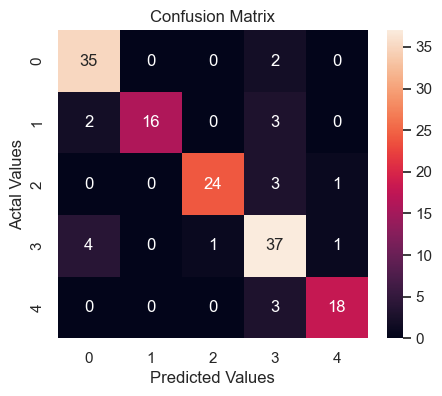

In [73]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test , y_pred)

cm_df = pd.DataFrame(cm , )

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()